# 1D regression 

In [157]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from qcl.testing.OneDimDataset import prepare_dataset,eval

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

from qcl.regressors.StandardQCLRegressor import StandardQCLRegressor
from qcl.gates.CNOTRotationGates import CNOTRotationGates
from qcl.Encoders.XYEncoder import XYEncoder
from qcl.Encoders.prerocess import *
from qcl.gates.Observable import ZObservable
from qcl.testing.DNNModel import DNNModel

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


loss 0.000006440947210
1/1 [==============================] - 0s 9ms/step
loss 0.006306824760431
1/1 [==============================] - 0s 11ms/step
loss 0.053899514762854
1/1 [==============================] - 0s 10ms/step
loss 0.000000329567295
1/1 [==============================] - 0s 10ms/step
loss 0.000003086774696
1/1 [==============================] - 0s 10ms/step


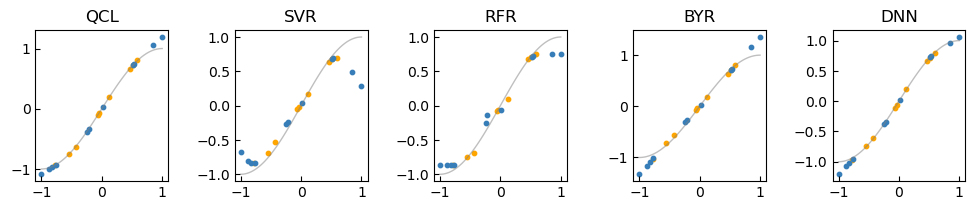

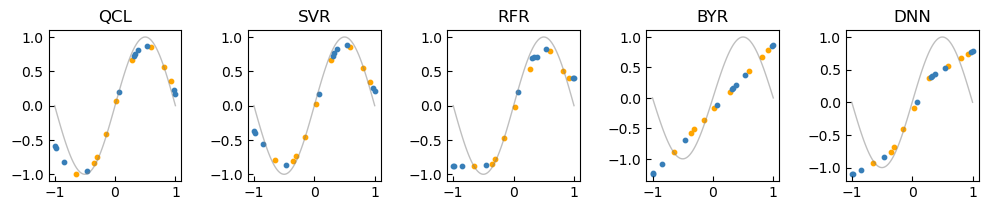

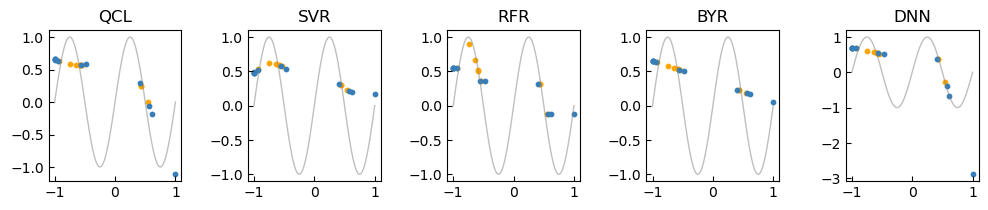

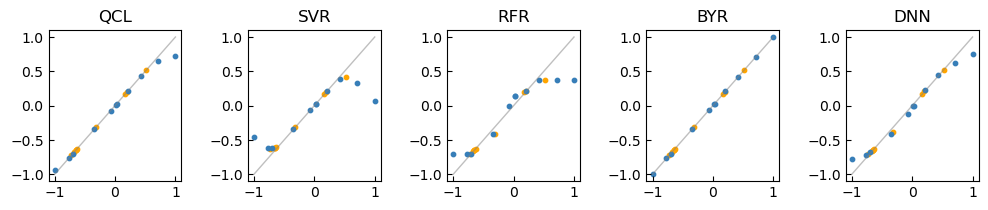

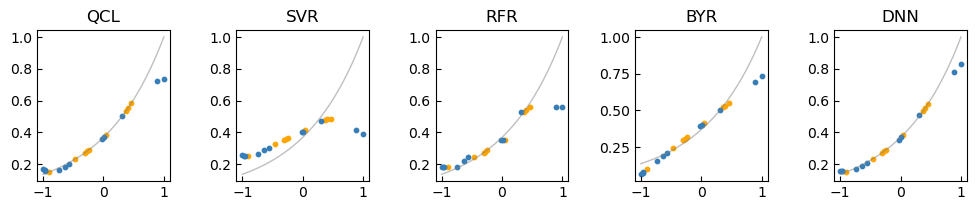

In [219]:
x_dim=1
n_qubit=2
depth=3
model_dict={}
model_dict["QCL"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
model_dict["SVR"]=SVR()
model_dict["RFR"]=RandomForestRegressor()
model_dict["BYR"]=BayesianRidge()
model_dict["DNN"]=DNNModel(hidden_dim=8,layers=1,activation="relu")


for n in [20]:
    for mode in ["sin1/2","sin","sin2","linear","exp"]:
        tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y=prepare_dataset(n_all_record=n,mode=mode,plot=False)
        i=0

        fig = plt.figure(figsize=(12,2),dpi=100)
        for model_name,model in model_dict.items():
            model.fit(tr_X,tr_y)
            plt.subplots_adjust(wspace=0.5, hspace=0.6)
            ax = fig.add_subplot(1, len(list(model_dict.keys())), i+1)
            eval(ax,model,tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y,title=model_name)
            i+=1


#circuit_drawer(model.vqe_gates.circuit)

# Analyze prediction process

loss 0.000001462244623
4/4 [==============================] - 0s 614us/step
loss 0.009115470673251
4/4 [==============================] - 0s 545us/step
loss 0.000001321050846
4/4 [==============================] - 0s 639us/step
loss 0.000000501152801
4/4 [==============================] - 0s 737us/step


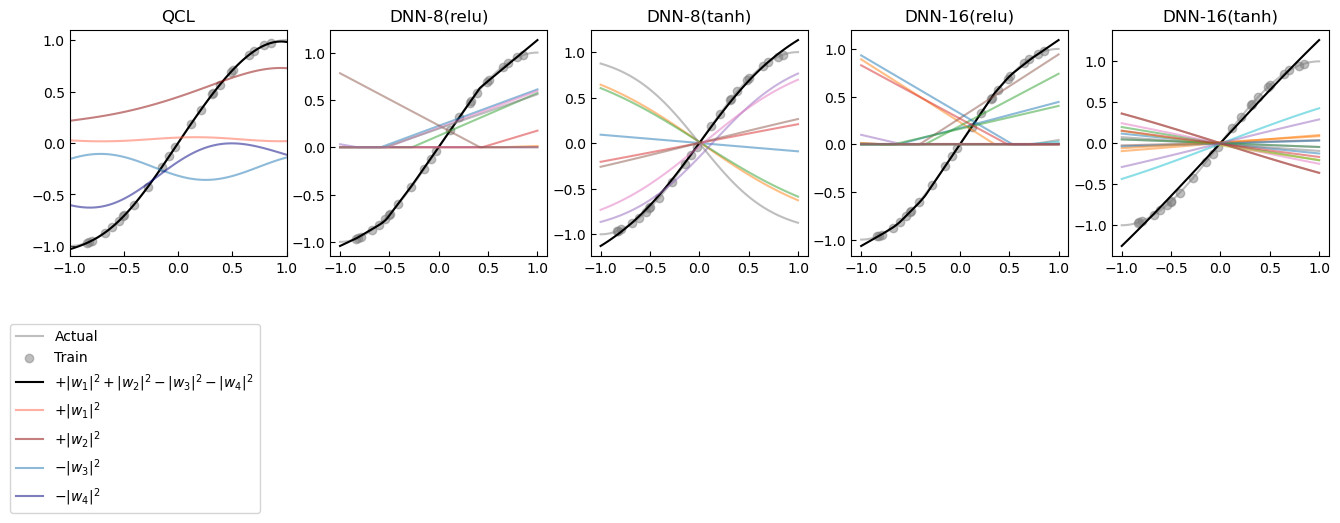

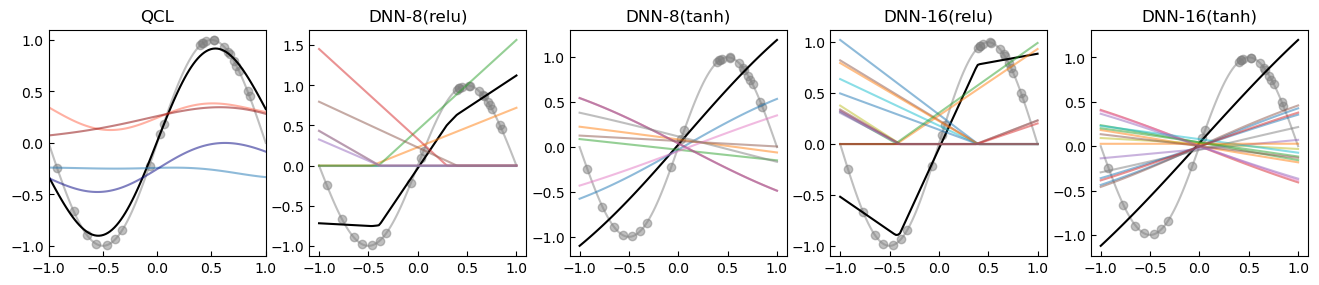

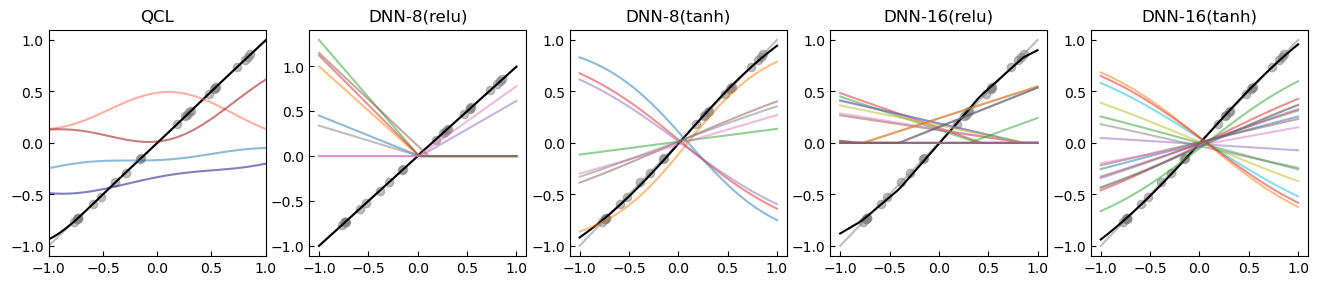

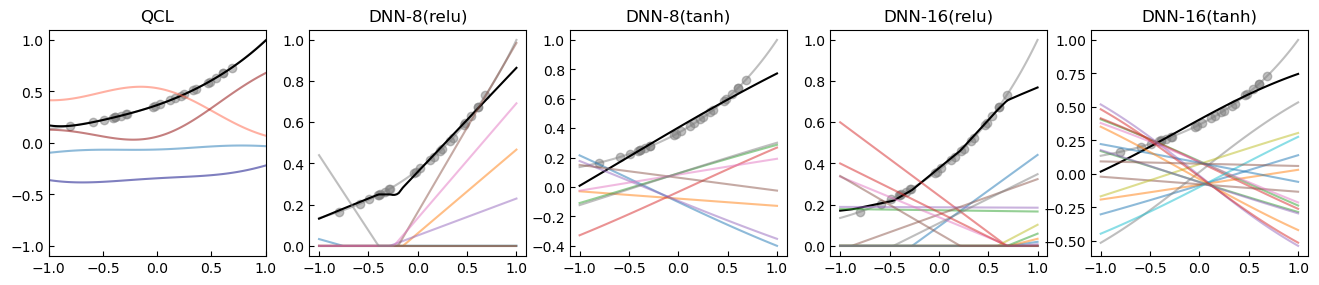

In [212]:
def conj(state_array,i):
    s=state_array[:,i]
    return (s*s.conj()).real

n_qubit=2
x_dim=1
mode="linear"

model_dict={}
model_dict["QCL"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
model_dict["DNN-8(relu)"]=DNNModel(hidden_dim=8,layers=1,activation="relu")
model_dict["DNN-8(tanh)"]=DNNModel(hidden_dim=8,layers=1,activation="tanh")
#model_dict["DNN-8-8"]=DNNModel(hidden_dim=8,layers=1,activation="relu")
model_dict["DNN-16(relu)"]=DNNModel(hidden_dim=16,layers=1,activation="relu")
model_dict["DNN-16(tanh)"]=DNNModel(hidden_dim=16,layers=1,activation="tanh")
#model_dict["DNN-16-16"]=DNNModel(hidden_dim=16,layers=1,activation="relu")
#model_dict["Arc"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit,preprocess_func=two_arc_angles,scaling_coeff=1),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))
#model_dict["Arc (scaled)"]=StandardQCLRegressor(x_dim=x_dim,n_qubit=n_qubit,encoder=XYEncoder(n_qubit,preprocess_func=two_arc_angles,scaling_coeff=0.8),observable=ZObservable(n_qubit=n_qubit,coeff=2),vqe_gates=CNOTRotationGates(n_qubit=n_qubit,depth=depth))

n_models=len(list(model_dict))
legend_flag=True
for mode in ["sin1/2","sin","linear","exp"]:

    fig = plt.figure(figsize=(3.25*n_models,3),dpi=100)
    tr_X,tr_y,te_inner_X,te_inner_y,te_low_X,te_low_y,te_high_X,te_high_y,act_X,act_y=prepare_dataset(n_all_record=n,mode=mode,plot=False)

    count=0
    for model_name,model in model_dict.items():
        count+=1
        ax = fig.add_subplot(1, n_models, count)

        ax.set_title(f"{model_name}")
        ax.plot(act_X,act_y,c="Gray",label="Actual",alpha=0.5)
        ax.scatter(tr_X,tr_y,label="Train",c="Gray",alpha=0.5)

        model.fit(tr_X,tr_y)

        if model_name=="QCL":

            # calculate complex states of |00>,|01>,|10>,|11> bases
            state_list=[]
            for xi in act_X:
                state = model.encoder(xi)
                state = model._calc_entangled_states(state)
                state=state.get_vector()
                state_list.append(state)

            state_array=np.array(state_list)

            #plot
            #fig = plt.figure(figsize=(3,3),dpi=100)

            #ax.set_title(f"{model_name} encoder - {mode} function")
            ty=+conj(state_array,0)
            ty-=conj(state_array,1)
            ty+=conj(state_array,2)
            ty-=conj(state_array,3)
            ax.plot(act_X,model.predict(act_X),c="black",label="$+|w_{1}|^{2}+|w_{2}|^{2}-|w_{3}|^{2}-|w_{4}|^{2}$",)
            ax.set_ylim(-1.1,1.1)
            ax.set_xlim(-1,1)
            ax.set_yticks(np.arange(-1,1.01, 0.5))

            #ax = fig.add_subplot(1, 2, 2)
            ax.plot(act_X,conj(state_array,0),label="$+|w_{1}|^{2}$",c="tomato",alpha=0.5)
            ax.plot(act_X,conj(state_array,2),label="$+|w_{2}|^{2}$",c="darkred",alpha=0.5)
            ax.plot(act_X,-conj(state_array,1),label="$-|w_{3}|^{2}$",alpha=0.5)
            ax.plot(act_X,-conj(state_array,3),label="$-|w_{4}|^{2}$",c="navy",alpha=0.5)
            if legend_flag:
                ax.legend(bbox_to_anchor=(0.3, -0.3), loc='upper center', borderaxespad=0, fontsize=10)
                legend_flag=False
            #ax.set_ylim(-1,1)
            #ax.set_xlim(-1,1)
            #ax.set_yticks([])

            #plt.legend()
            #break
        if model_name.find("DNN")>=0:
            ax.plot(act_X,model.predict(act_X),c="black",label="Predict",)

            hidden_vecs=model.hidden_predict(act_X)
            for d in range(hidden_vecs.shape[1]):
                #ax = fig.add_subplot(1, 2, 1)
                plt.plot(act_X,hidden_vecs[:,d].reshape(-1),label=f"Hidden-{d+1}",alpha=0.5)
    

In [217]:

for model_name,model in model_dict.items():
    try:
        print(model_name)
        model.dnn.summary()
    except:
        pass

QCL
DNN-8(relu)
Model: "sequential_287"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_888 (Dense)           (None, 1)                 2         
                                                                 
 dense_889 (Dense)           (None, 8)                 16        
                                                                 
 dense_890 (Dense)           (None, 1)                 9         
                                                                 
Total params: 27
Trainable params: 27
Non-trainable params: 0
_________________________________________________________________
DNN-8(tanh)
Model: "sequential_288"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_891 (Dense)           (None, 1)                 2         
                                                                 
 den

In [222]:
model_dict["QCL"].vqe_gates.get_n_params()

15